# Dynamic Time Warping for Non-Anthropomorphic Hand Data

In [ ]:
pip install fastdtw

In [1]:
# Set up:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits import mplot3d

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [2]:
def dtw_data_import(set_num, run):

#     Y-position of hand and end-effector tend to be most consistently aligned. Use those to discover the time warp mapping

    filename = "C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\j2s6s300_end_effectorMotion_"+str(run)+".csv"
    # Import data from csvs
    end_eff_raw = pd.read_csv(filename)
    end_eff_data = end_eff_raw.to_numpy()
    
    filename = "C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\RightHandAnchorMotion_"+str(run)+".csv"
    hand_raw = pd.read_csv(filename)
    hand_data = hand_raw.to_numpy()
    
    filename = "C:\\Users\\jmoln\\Documents\\Projects\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\j2s6s300_JointMotion_"+str(run)+".csv"
    jointangles = pd.read_csv(filename)
    joint_data = jointangles.to_numpy()

    return end_eff_data, hand_data, joint_data



In [3]:
def norm_data(set_num, run, end_eff_data, hand_data):

    x = (end_eff_data[...,0],end_eff_data[...,2])
    y = (hand_data[...,0],hand_data[...,2])
    
    # Normalize x and y to prevent scaling issues from creating DTW misalignment

    scale_x = 1/(np.max(x[1])-np.min(x[1]))
    scale_y = 1/(np.max(y[1])-np.min(y[1]))

    center_x = np.mean(x[1])
    center_y = np.mean(y[1])

    x_norm = (x[0],(x[1] - center_x)*scale_x)
    y_norm = (y[0],(y[1] - center_y)*scale_y)

    # TO-DO: trim ends for cleaner DTW
    # (Not done yet)

    dtw_distance, warp_path = fastdtw(x_norm[1], y_norm[1], dist=euclidean) 
    plot_norm(set_num, run, warp_path, x_norm, y_norm)
    
    return warp_path

In [4]:
def plot_norm(set_num, run, warp_path, x_norm, y_norm):
    # Show normalized plots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Remove the border and axes ticks
    fig.patch.set_visible(True)
    ax.axis('on')

    max_distance = 0;
    i = 0;

    for [map_x, map_y] in warp_path:

        ax.plot([map_x, map_y], [x_norm[1][map_x], y_norm[1][map_y]], '--k', linewidth=0.2)
        temp_arr2 = np.array((x_norm[1][map_x], y_norm[1][map_y]))
        max_distance = np.maximum(max_distance, np.linalg.norm(temp_arr2))
        i=i+1


    ax.plot(x_norm[1][:], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    ax.plot(y_norm[1][:], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

    ax.set_title("Normalized DTW Distance", fontsize=10, fontweight="bold")
    plt.savefig('NormDTW_Y_'+str(run)+'.png')
    plt.close('all')
    
    return

In [5]:
# Take the warp_path generated from normalized hand/URDF data and use that to align all other hand data
def full_align(warp_path, end_eff_data, hand_data):
    # Time marks: 
    time_URDF = end_eff_data[...,0]
    time_hand = hand_data[...,0]

    # remember that x = end_eff_pos
    #               y = hand_pos

    # Z-data (forward/back) is offset by the distance between the viewer and the robot. Let's remove that distance for comparison purposes

    wp_size = len(warp_path)
    time_URDF_aligned = np.zeros(wp_size)
    time_hand_aligned = np.zeros(wp_size)
    end_eff_pos_aligned = np.zeros((wp_size,3))
    end_eff_rot_aligned = np.zeros((wp_size,3))
    hand_pos_aligned = np.zeros((wp_size,3))
    hand_rot_aligned = np.zeros((wp_size,3))

    for i, [map_x, map_y] in enumerate(warp_path, start=0):   
        time_URDF_aligned[i] = time_URDF[map_x]
        time_hand_aligned[i] = time_hand[map_y]
        end_eff_pos_aligned[i][0:3] = end_eff_data[map_x][1:4]
        end_eff_rot_aligned[i][0:3] = end_eff_data[map_x][4:]
        hand_pos_aligned[i][0:3]    = hand_data[map_y][1:4]
        hand_rot_aligned[i][0:3]    = hand_data[map_y][4:]
    
    return time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned

def full_joint_align(warp_path, joint_data, hand_data):
    # Time marks: 
    time_ja   = joint_data[...,0]
    time_hand = hand_data[...,0]

    # remember that x = end_eff_pos
    #               y = hand_pos

    # Z-data (forward/back) is offset by the distance between the viewer and the robot. Let's remove that distance for comparison purposes

    wp_size = len(warp_path)
    time_ja_aligned   = np.zeros(wp_size)
    time_hand_aligned = np.zeros(wp_size)
    joint_data_aligned = np.zeros((wp_size,6))
    hand_data_aligned = np.zeros((wp_size,6))

    for i, [map_x, map_y] in enumerate(warp_path, start=0):   
        time_ja_aligned[i]   = time_ja[map_x]
        time_hand_aligned[i] = time_hand[map_y]
        joint_data_aligned[i][0:5] = end_eff_data[map_x][1:6]
        hand_data_aligned[i][0:5]    = hand_data[map_y][1:6]
    
    return time_ja_aligned, time_hand_aligned, joint_data_aligned, hand_data_aligned

In [6]:
def plot_pos(set_num, run, warp_path, end_eff_pos_aligned, hand_pos_aligned):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks,
    fig.patch.set_visible(True)
    ax.axis('on')

    ax = plt.axes(projection='3d')

    # ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[0], '-ro', label='End-effector position', \
    #     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    # ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[1], '-ro', label='End-effector position', \
    #     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    # ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[2], '-ro', label='End-effector position', \
    #     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')

    # Unity uses a left-handed coordinate system, so plot your position data in the orientation in which it was gathered:
    #  X moving left to right, Z moving front to back, and Y pointing up and down
    ax.scatter(end_eff_pos_aligned[:].T[0], -end_eff_pos_aligned[:].T[2], end_eff_pos_aligned[:].T[1], \
                c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector position')
    ax.scatter(hand_pos_aligned[:].T[0]   , -hand_pos_aligned[:].T[2]   , hand_pos_aligned[:].T[1]   , \
               c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

    # ax.plot3D(end_eff_pos_aligned[:].T[0], end_eff_pos_aligned[:].T[1], end_eff_pos_aligned[:].T[2], \
    #     '-ro', label='End-effector position', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    # ax.plot3D(hand_pos_aligned[:].T[0]   , hand_pos_aligned[:].T[1]   , hand_pos_aligned[:].T[2]   , \
    #     '-bo', label='Hand position', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

    for [map_x, map_y] in warp_path: 
        ax.plot3D([end_eff_pos_aligned[map_x].T[0], hand_pos_aligned[map_y].T[0]], \
                  [-end_eff_pos_aligned[map_x].T[2], -hand_pos_aligned[map_y].T[2]],\
                  [end_eff_pos_aligned[map_x].T[1], hand_pos_aligned[map_y].T[1]], \
                  '--k', linewidth=0.2)

    ax.set_xlabel('Horizontal position')
    ax.set_ylabel('Forward/Back position')
    ax.set_zlabel('Vertical position')

    ax.set_title("DTW Alignment of Hand and URDF End-Effector Position", fontsize=10, fontweight="bold")
    plt.savefig('DTW_Pos'+str(run)+'.png')
    plt.close('all')
    
    return

In [7]:
def clean_rot_data(set_num, run, hand_rot_aligned):
    # Fix angle inversion issues for hand data

    fig, ax = plt.subplots(figsize=(10, 7))

    for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=1):
        # Singularities should occur in all axes simultaneously
        if i==len(hand_rot_aligned):
            continue
        elif np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-1].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-1].T[0]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]
        elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-1].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-1].T[1]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]
        elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-1].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-1].T[2]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]


    # for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=2):
    #     # Singularities should occur in all axes simultaneously
    #     if np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-2].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-2].T[0]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]
    #     elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-2].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-2].T[1]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]
    #     elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-2].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-2].T[2]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]

    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[0], '-ko', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[1], '-bo', label='x', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[2], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='red', markeredgecolor='red')

    plt.savefig('DTW_Rot_corrected_'+str(run)+'.png')
    plt.close('all')
    
    return hand_rot_aligned

In [8]:
def plot_rot(set_num, run, warp_path, end_eff_rot_aligned, hand_rot_aligned):
    # Plot DTW-aligned hand/end-effector orientation

    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks
    fig.patch.set_visible(True)
    ax.axis('on')

    ax = plt.axes(projection='3d')

    ax.scatter(end_eff_rot_aligned[:].T[0], -end_eff_rot_aligned[:].T[2], end_eff_rot_aligned[:].T[1], \
              c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
    ax.scatter(hand_rot_aligned[:].T[0]   , -hand_rot_aligned[:].T[2]   , hand_rot_aligned[:].T[1]   , \
              c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')

    for [map_x, map_y] in warp_path: 
        ax.plot3D([end_eff_rot_aligned[map_x].T[0], hand_rot_aligned[map_y].T[0]], \
                  [-end_eff_rot_aligned[map_x].T[2], -hand_rot_aligned[map_y].T[2]],\
                  [end_eff_rot_aligned[map_x].T[1], hand_rot_aligned[map_y].T[1]], \
                  '--k', linewidth=0.2)

    ax.set_title("DTW Alignment of Hand and URDF End-Effector Orientation", fontsize=10, fontweight="bold")
    plt.savefig('DTW_Rot'+str(run)+'.png')
    plt.close('all')
    
    return

In [11]:
# Functions are all defined. Let's grab some data sets and get them ordered
for set_num in range(1):
#     print(set_num)
    for run in range(1,11):
#         print(set_num, run)
        end_eff_data, hand_data, joint_data = dtw_data_import(set_num, run)
        warp_path = norm_data(set_num, run, end_eff_data, hand_data)
        time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned = \
            full_align(warp_path, end_eff_data, hand_data)
        hand_rot_aligned = clean_rot_data(set_num, run, hand_rot_aligned)
        hand_rot_aligned = clean_rot_data(set_num, run, hand_rot_aligned) #Seems to work better if you do it twice for some reason
        plot_pos(set_num, run, warp_path, end_eff_pos_aligned, hand_pos_aligned)
        plot_rot(set_num, run, warp_path, end_eff_rot_aligned, hand_rot_aligned)
        
        np.savez('data_'+str(set_num)+'_'+str(run),time_URDF_aligned=time_URDF_aligned, time_hand_aligned=time_hand_aligned,\
                end_eff_pos_aligned=end_eff_pos_aligned, end_eff_rot_aligned=end_eff_rot_aligned, \
                hand_pos_aligned=hand_pos_aligned, hand_rot_aligned=hand_rot_aligned, \
                set_num=set_num, run=run, warp_path=warp_path, end_eff_data=end_eff_data, hand_data=hand_data)


In [47]:
set_num=0
run = 1

end_eff_data, hand_data = dtw_data_import(set_num, run)
jointangle_data  = dtw_jointangles_import(set_num, run)

hand_data[...,0]=hand_data[...,0]-min(hand_data[...,0])
jointangle_data[...,0]=jointangle_data[...,0]-min(jointangle_data[...,0])

dtw_distance, warp_path_ja = fastdtw(jointangle_data[...,0], hand_data[...,0], dist=euclidean) 

time_ja    = jointangle_data[...,0]
time_hand  = hand_data[...,0]

wp_size             = len(warp_path_ja)
time_ja_aligned     = np.zeros(wp_size)
time_hand_aligned   = np.zeros(wp_size)
ja_data_aligned     = np.zeros((wp_size,14))
hand_data_aligned   = np.zeros((wp_size,7))

for i, [map_x, map_y] in enumerate(warp_path_ja, start=0):   
    time_ja_aligned[i]   = time_ja[map_x]
    time_hand_aligned[i] = time_hand[map_y]
    ja_data_aligned[i]      = jointangle_data[map_x][:]
    hand_data_aligned[i]  = hand_data[map_y]
    
np.savez('ja_data_'+str(set_num)+'_'+str(run),time_ja_aligned=time_ja_aligned, time_hand_aligned=time_hand_aligned,\
                hand_data_aligned=hand_data_aligned, ja_data_aligned=ja_data_aligned,set_num=set_num, run=run, warp_path=warp_path_ja)

Text(0.5, 0.92, 'DTW Alignment of Hand Position and First Three URDF Joint Angles')

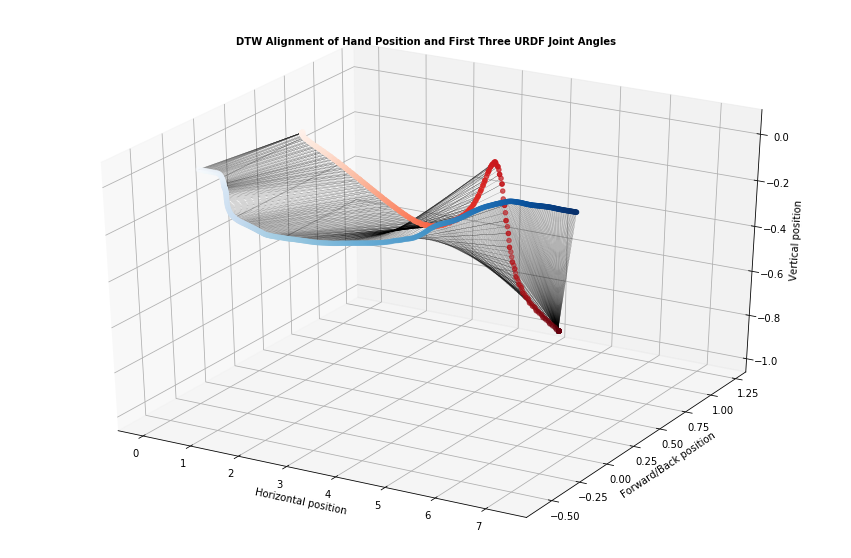

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')

ax.scatter(ja_data_aligned[...,2], ja_data_aligned[...,3], ja_data_aligned[...,4], \
          c=time_ja_aligned/max(time_ja_aligned), cmap='Reds', label='Joint Angle Values')
ax.scatter(hand_data_aligned[...,0]   , -hand_data_aligned[...,2]   , hand_data_aligned[...,1]   , \
          c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

for [map_x, map_y] in warp_path_ja: 
    ax.plot3D([ja_data_aligned[map_x].T[2], hand_data_aligned[map_y].T[0]], \
              [ja_data_aligned[map_x].T[3], -hand_data_aligned[map_y].T[2]],\
              [ja_data_aligned[map_x].T[4], hand_data_aligned[map_y].T[1]], \
              '--k', linewidth=0.2)
    
ax.set_xlabel('Horizontal position')
ax.set_ylabel('Forward/Back position')
ax.set_zlabel('Vertical position')

ax.set_title("DTW Alignment of Hand Position and First Three URDF Joint Angles", fontsize=10, fontweight="bold")


In [25]:
ja_data_aligned

array([ 2.654425e+01,  5.357381e-01,  4.155194e+00,  1.221421e+00,
       -9.872516e-01,  4.305063e+00, -2.889063e+00,  1.066583e-05,
        1.828993e-05,  3.128089e-09,  0.000000e+00,  0.000000e+00,
        0.000000e+00,           nan])